# Clinic work flow data mining
## Radiation therapy work flow data mining  
## Project: To improve the clinic treatment efficiency and optimize the scheduling

In radiation oncology department, the work is done by the colabration of physician, dosimetrists and physicists. Usually, every deparment has multiple machines and multiple treatment techniques. Every machine and treatment technique varies in treatment planning and delivery time. Ususally, we would like the the plan need to be approved by physician 2 days before treatment, but it is hard to obey this rule. 

In this study, we are going to data mining clinic operation data for the optimal treatment scheduling.


## Clean the Data
We will load the data into dataframe and the columns are

- OrderID, Physician, Physicist, Dosimetrist, tech, machine, sim-treat-day, approve-treat-day, Treatment-site... 

The data was cleaned that any row with NA or approve-treat-day<0 or approve-treat-day>10 was removed



In [12]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
import io
from IPython import display
import matplotlib.pyplot as plt


#read excel file with path directory
df_all_data = pd.read_excel(r'./data.xlsx')
df_all_data.insert(2,'Sim_Day',df_all_data['Completed_First_Sim'].dt.day_name())
df_all_data.head()

,OrderId,Completed_First_Sim,Sim_Day,Plan_Approval,Complete_First_Treatment,Sim_Treat_Day,PlanApproval_Treat_Day,Cal_Days_Sim_Treat,Cal_Days_PlanApproval_Treat,Diagnosis,Attending,Tx_Technique,Tx_Machine,Sim_Physicist,Sim_Dosimetrist
0,303014,2021-03-08 14:00:00,Monday,2021-03-15 13:46:47.853,2021-03-16 14:30:00,6.0,1,8.0,1,NaN,"Wong, Jeffrey",IMRT,Tomo 1,SZ,JJN
1,303350,2021-03-09 15:00:00,Tuesday,2021-03-15 15:46:20.243,2021-03-16 14:30:00,5.0,1,7.0,1,C79.31[Secondary malignant neoplasm of brain],"Chen, YiJen",SRS-Vision RT,TB STX,CH,TV
2,302804,2021-03-05 14:00:00,Friday,2021-03-15 13:58:29.673,2021-03-16 14:00:00,7.0,1,11.0,1,C01[Malignant neoplasm of base of tongue],"Amini, Arya",IMRT,Tomo 2,DD,TJ
3,302426,2021-03-04 08:00:00,Thursday,2021-03-15 14:07:58.713,2021-03-16 10:30:00,8.0,1,12.0,1,C10.8[Malignant neoplasm of overlapping sites ...,"Amini, Arya",IMRT,Tomo 2,TW,RM
4,303124,2021-03-09 10:00:00,Tuesday,2021-03-15 18:35:23.303,2021-03-16 10:15:00,5.0,1,7.0,1,C50.411[Malig neoplm of upper-outer quadrant o...,"Radany, Eric",3D/2D,TB 1,TW,TJ


### Clean the outliers and empty data (with 'NA' or 'tbd'), and any sim(approval)-treat-day < 0

In [13]:
df_all_data.dropna(inplace = True) #clean NA values
df_all_data.drop(df_all_data.loc[df_all_data['Tx_Technique']=='*tbd*'].index, inplace=True)
df_all_data.drop(df_all_data.loc[df_all_data['Tx_Machine']=='*tbd*'].index, inplace = True)
df_all_data.drop(df_all_data.loc[df_all_data['Tx_Machine']=='21 Ex'].index, inplace = True)
df_all_data.replace(to_replace = "SRS-Aktina",value = "SRS-Vision RT", inplace = True)
df_all_data.drop(df_all_data.loc[df_all_data['Sim_Treat_Day']<0].index, inplace = True)
df_all_data.drop(df_all_data.loc[df_all_data['PlanApproval_Treat_Day']<0].index, inplace = True)
print('the number of records {}'.format(len(df_all_data)))

the number of records 1319


## Exploring Data 
Let's begin by investigating the dataset to determine what are the insights that we can get by just simply make some statiscs.

The information we are interested are following:
- The cases histograme of attending, physicist, dosimetrist, `case_x`. x: 'phy","att","dos"
- The number of `Sim_Treat_Day` and `PlanApproval_Treat_Day` with varibles (x-axis)
    - Attending
    - Dosimetrist
    - Tx_Technique
    - Machine
- The `Attending` and `Tx_Technique` incidence with the `Sim_Treat_Day`
- The trend of, `PlanApproval_Treat_Day`.
- The trend of, `Sim_Treat_Day`.
- The trend of average daily cases

### **Histograms of the data**

### Observation
- Some attendings and dosimetrist take more data

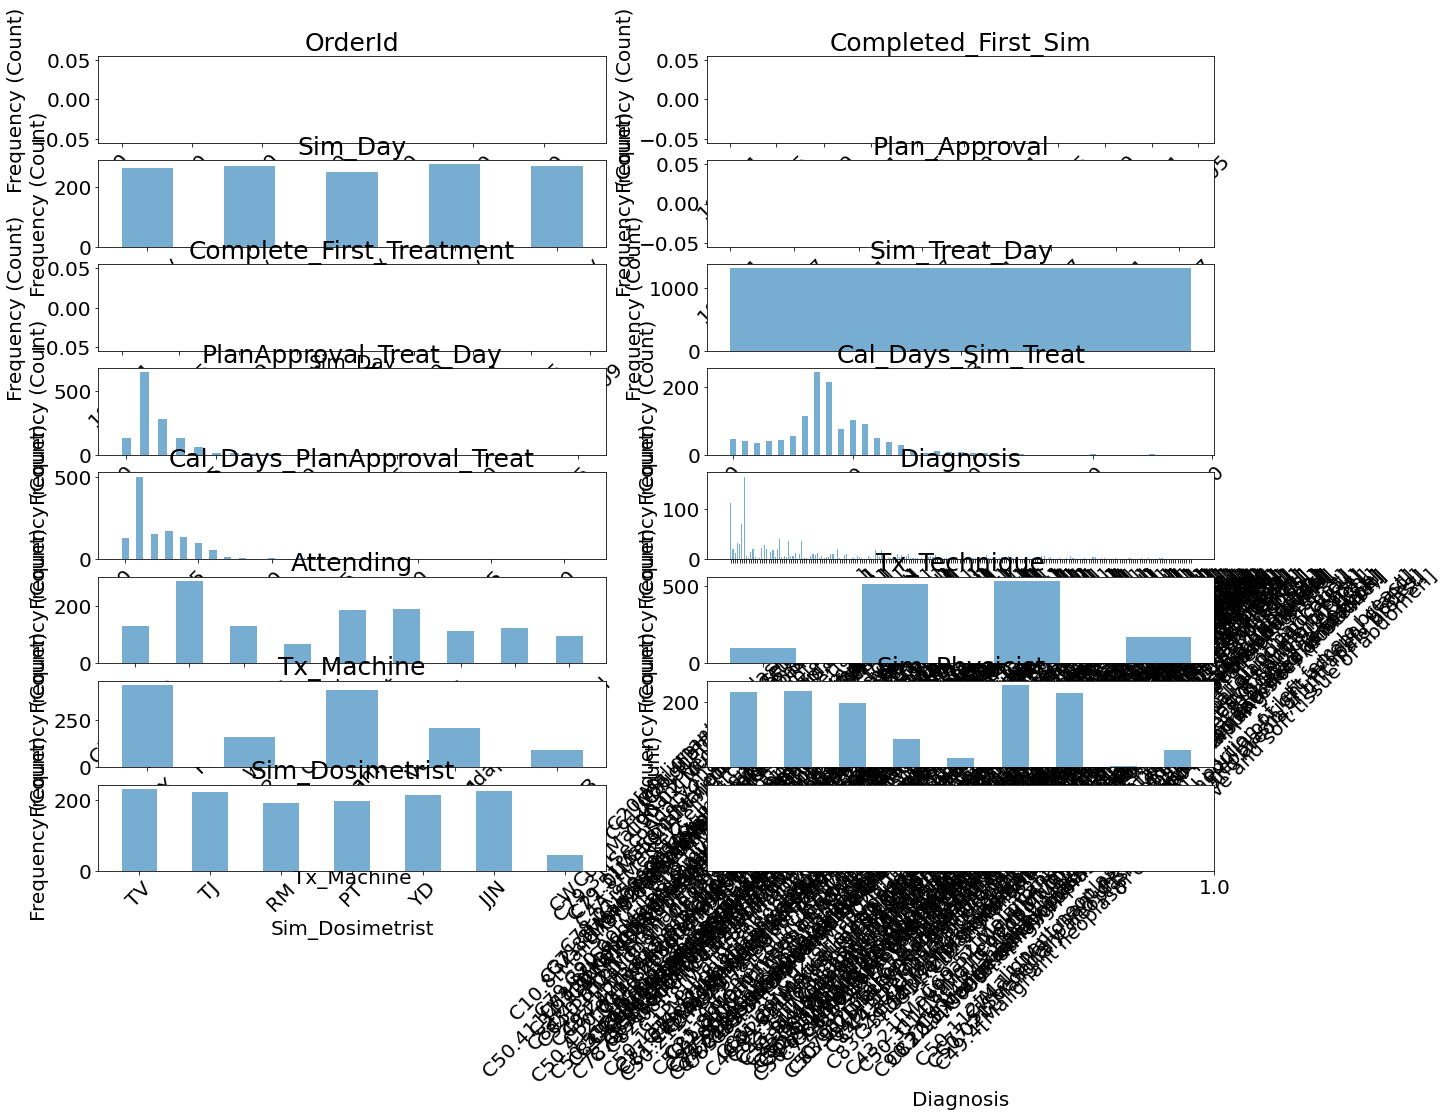

In [22]:
# histograms
import matplotlib.pyplot as plt
#%matplotlib inline

# first define a new dataframe
df_hist = df_all_data.copy()

'''
df_hist = {
    'Sim_Physicist': df_all_data['Sim_Physicist'].astype(str),
    'Sim_Dosimetrist': df_all_data['Sim_Dosimetrist'].astype(str), 
    'Attending': df_all_data['Attending'].astype(str), 
    'Tx_Machine': df_all_data['Tx_Machine'].astype(str),
    'Tx_Technique': df_all_data['Tx_Technique'].astype(str),
    'Sim_Treat_Day': df_all_data['Sim_Treat_Day'].astype(int),
    'Sim_Day': df_all_data['Sim_Day'].astype(str)}
'''


# convert the 'Sim_Treat_Day' into different inverval [0,2], [3, 6], [7,]
cond_1 = (df_hist['Sim_Treat_Day'] >= 0) & (df_hist['Sim_Treat_Day'] <= 3)
cond_2 = df_hist['Sim_Treat_Day'] >= 4
df_hist.loc[cond_1, 'Sim_Treat_Day'] = '0 to 3'
df_hist.loc[cond_2 , 'Sim_Treat_Day'] = '0 to 3'

n_att = len(df_hist.columns)
col = 2
row = int((n_att+1)/2)

## plot the hist
fig, axs = plt.subplots(row,col, figsize = (20,15))

for index, att in enumerate(list(df_hist.columns)):
    r = int(index/2)
    c = index%2
    axs[r,c].hist(list(df_hist[att]), bins = np.arange(len(pd.unique(list(df_hist[att])))+1)-0.5, rwidth = 0.5, alpha = 0.6)
    axs[r,c].set_title(att, fontsize = 25)
    axs[r,c].set_xlabel(att, fontsize =20)
    axs[r,c].tick_params(axis='x', labelrotation = 45)


for ax in axs.flat:
    ax.set_ylabel('Frequency (Count)',fontsize = 20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

#plt.tight_layout()

#plt.hist(df['Sim_Physicist'], align="right",bins = 8, rwidth = 0.5, alpha = 0.5)


### The number of `Sim_Treat_Day` and `PlanApproval_Treat_Day` with varibles (x-axis)
    - Attending
    - Dosimetrist
    - Tx_Technique
    - Machine

In [ ]:
# stacked bar of 'clinic days plan approval treat'
a = np.array(df['Clinic_Days_PlanApproval_Treat'].values.tolist())
df['Clinic_Days_PlanApproval_Treat'] = np.where(a > 3, 4, a).tolist()
#indexNames = df[df['Clinic_Days_PlanApproval_Treat'] <= -1 ].index
#df.drop(indexNames , inplace=True)

techniquedf = df[['Clinic_Days_PlanApproval_Treat','Tx_Technique']].dropna()
diagnosisdf = df[['Clinic_Days_PlanApproval_Treat','Diagnosis']].dropna()
machinedf = df[['Clinic_Days_PlanApproval_Treat','Tx_Machine']].dropna()
physicistdf = df[['Clinic_Days_PlanApproval_Treat','Sim_Physicist']].dropna()
dosimetristdf = df[['Clinic_Days_PlanApproval_Treat','Sim_Dosimetrist']].dropna()

techniquedata = techniquedf.groupby(["Clinic_Days_PlanApproval_Treat","Tx_Technique"]).size().reset_index()
machinedata = machinedf.groupby(["Clinic_Days_PlanApproval_Treat","Tx_Machine"]).size().reset_index()
diagnosisdata = diagnosisdf.groupby(["Clinic_Days_PlanApproval_Treat","Diagnosis"]).size().reset_index()
physicistdata = physicistdf.groupby(["Clinic_Days_PlanApproval_Treat","Sim_Physicist"]).size().reset_index()
dosimetristdata = dosimetristdf.groupby(["Clinic_Days_PlanApproval_Treat","Sim_Dosimetrist"]).size().reset_index()

tech = techniquedata.pivot(index = 'Clinic_Days_PlanApproval_Treat', columns = 'Tx_Technique').fillna(0)
mach = machinedata.pivot(index = 'Clinic_Days_PlanApproval_Treat',columns = 'Tx_Machine').fillna(0)
diag = diagnosisdata.pivot(index = 'Clinic_Days_PlanApproval_Treat', columns = 'Diagnosis').fillna(0)
phys = physicistdata.pivot(index = 'Clinic_Days_PlanApproval_Treat', columns = 'Sim_Physicist').fillna(0)
dos = dosimetristdata.pivot(index = 'Clinic_Days_PlanApproval_Treat', columns='Sim_Dosimetrist').fillna(0)

tech1 = techniquedata.pivot(index = 'Tx_Technique', columns = 'Clinic_Days_PlanApproval_Treat').fillna(0)
mach1 = machinedata.pivot(index = 'Tx_Machine',columns = 'Clinic_Days_PlanApproval_Treat').fillna(0)
diag1 = diagnosisdata.pivot(index = 'Diagnosis', columns = 'Clinic_Days_PlanApproval_Treat').fillna(0)
phys1 = physicistdata.pivot(index = 'Sim_Physicist', columns = 'Clinic_Days_PlanApproval_Treat').fillna(0)
dos1 = dosimetristdata.pivot(index = 'Sim_Dosimetrist', columns='Clinic_Days_PlanApproval_Treat').fillna(0)

ax0 = mach.plot(kind = 'bar', stacked = True)
ax1 = mach1.plot(kind = 'bar', stacked = True)

ax2 = tech.plot(kind='bar', stacked=True)
ax3 = tech1.plot(kind = 'bar', stacked = True)

ax4 = phys.plot(kind='bar', stacked=True)
ax5 = phys1.plot(kind = 'bar', stacked = True)

ax6 = dos.plot(kind='bar', stacked=True)
ax7 = dos1.plot(kind = 'bar', stacked = True)

ax = [ax0,ax2,ax4, ax6]
for ax in ax:
    ax.set_xlabel("Score on Clinic Dats Plan Approval Treat")
    ax.set_ylabel("Count or Frequency")
    ax.tick_params(axis = 'x', labelrotation = 0)
    
axf = [ax1,ax3,ax5,ax7]
for ax in axf:
    ax.set_xlabel("Category")
    ax.set_ylabel("Count or Frequency")
    ax.tick_params(axis = 'x', labelrotation = 0)

### The trend of, `PlanApproval_Treat_Day`. The trend of, `Sim_Treat_Day`. The trend of average daily cases

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

df['Complete_First_Treatment'] = pd.to_datetime(df['Complete_First_Treatment'])
timedf = df[["Complete_First_Treatment","Clinic_Days_PlanApproval_Treat"]].dropna()
timedf['month'] = timedf['Complete_First_Treatment'].dt.month
timedf['year'] = timedf['Complete_First_Treatment'].dt.year
timedf.head()


sns.lineplot(timedf['month'], timedf['Clinic_Days_PlanApproval_Treat'], hue = timedf['year'])

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the data into feature and target columns to see if any features are non-numeric.

In [ ]:
# Extract feature columns 'Attending', 'Tx_Technique' ,'Sim_Treat_Day', 'Sim_Dosimetrist', 'Completed_First_Sim'

feature_cols = list(df_all_data.columns[:-1])
feature_cols = ['']

# Extract target column 'PlanApproval-Treat-Day'
target_col = df_all_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = df_data_all[feature_cols]
y_all = df_data_all[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [ ]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [ ]:
# TODO: Import any additional functionality you may need here

# TODO: Set the number of training points
num_train = None

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train = None
X_test = None
y_train = None
y_test = None

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [ ]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [ ]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
# from sklearn import model_B
# from sklearn import model_C

# TODO: Initialize the three models
clf_A = None
clf_B = None
clf_C = None

# TODO: Set up the training set sizes
X_train_100 = None
y_train_100 = None

X_train_200 = None
y_train_200 = None

X_train_300 = None
y_train_300 = None

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - ?**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                         |                        |                  |                 |
| 200               |        EXAMPLE          |                        |                  |                 |
| 300               |                         |                        |                  |    EXAMPLE      |

** Classifer 2 - ?**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                         |                        |                  |                 |
| 200               |     EXAMPLE             |                        |                  |                 |
| 300               |                         |                        |                  |     EXAMPLE     |

** Classifer 3 - ?**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                         |                        |                  |                 |
| 200               |                         |                        |                  |                 |
| 300               |                         |                        |                  |                 |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [ ]:
# TODO: Import 'GridSearchCV' and 'make_scorer'

# TODO: Create the parameters list you wish to tune
parameters = None

# TODO: Initialize the classifier
clf = None

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = None

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = None

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = None

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.